# PCA-eval : evaluating Principal Component Analysis (PCA) performance in high-dimensional data

I created this simple package to evaluate whether PCA sucessfully carries most of the data variance in single-cell genomics. It should work for any high-dimensional data. In a nutshell, this helps practitioners evaluate whether they can perform PCA for denoising and reduction of computational burden before proceeding with sophisticated non-linear methods.

Let's start to see how to use this package with some simple simulated data:

In [1]:
from pcaeval.pca_eval import (generate_linear_data,
                              generate_uncorrelated_data,
                              evaluate_matrix,
                              plot_sing_vals_exp_var,
                              print_dict_results)

We'll simulate gaussian blolbs, linearly correlated data (a simple classification dataset) and uncorrelated data to validate the analysis pipeline.

In [2]:
from sklearn.datasets import make_blobs

blobs_test, _ = make_blobs(n_samples=10000, n_features=2000, centers=10, random_state=0)
linear_test = generate_linear_data(n=10000, d=2000, n_classes=10, redundancy=0.1, noise=0.1, seed=0)
uncorrelated_test = generate_uncorrelated_data(n=10000, d=2000, seed=0)

datasets = {'Gaussian blobs': blobs_test,'Linear data':linear_test, 'Uncorrelated data':uncorrelated_test}

Next, we'll evaluate these data matrices with our `evaluate_matrix()` function. It yields a dictionary of results.

In [3]:
results_dict = {}
for i_data, name in enumerate(datasets):
    r_dict = evaluate_matrix(
        datasets[name], n_pcs=100, dimred_estimator=False,
     clustering_estimator=False, n_jobs=-1, verbose=True
     )
    results_dict[name] = r_dict

No precomputed kNN graph specified, computing...
No precomputed kNN graph specified, computing...
No precomputed kNN graph specified, computing...


Finally, let's plot the covariance eigenspectrum (singular values and cumulative explained variance):

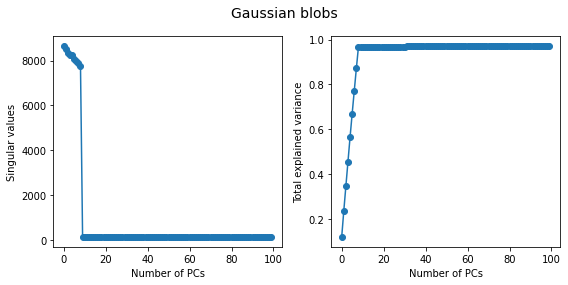

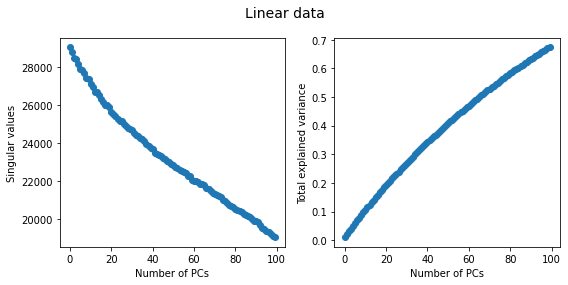

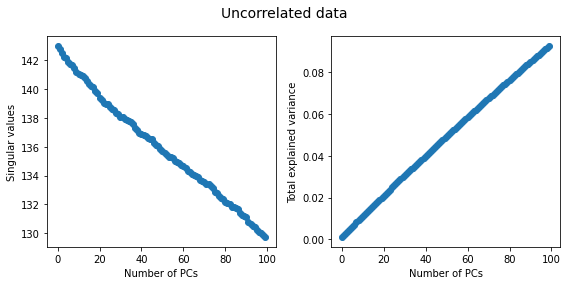

In [4]:
plot_sing_vals_exp_var(results_dict, fontsize=10)

As one can see, PCs explain very little variance and fail to meaningfully represent the data when it is not linearly correlated.

An example of how this can be important is neighborhood graph construction: often machine-learning or bioinformatics practitioners learn nearest-neighbors graphs on top PCs instead of using the full data. However, the graph learned from the PCs is poorly correlated with the graph learned from the full data when features are not linearly correlated (i.e. data cannot be represented by hyperplanes of maximum covariance):

In [5]:
print_dict_results(results_dict)


 
  --- Gaussian blobs --- 
 Spearman R correlation between the k-nearest-neighbors graphs learned from the data and the Principal Components: 0.053341
 Spearman R correlation between the UMAP embeddings learned from these graphs 0.000000
 Total explained variance with the first 100 PCs: 0.970851

 
  --- Linear data --- 
 Spearman R correlation between the k-nearest-neighbors graphs learned from the data and the Principal Components: 0.381507
 Spearman R correlation between the UMAP embeddings learned from these graphs 0.000000
 Total explained variance with the first 100 PCs: 0.674334

 
  --- Uncorrelated data --- 
 Spearman R correlation between the k-nearest-neighbors graphs learned from the data and the Principal Components: 0.015603
 Spearman R correlation between the UMAP embeddings learned from these graphs 0.000000
 Total explained variance with the first 100 PCs: 0.092572


Thus, as we can see, building the k-nearest-neighbors graph from PCs when data features are not linearly correlated is often a bad idea. The same goes for other algorithms with locality-preserving characteristics, such as non-linear dimensional reduction.

Let's see how this goes for UMAP, a very popular dimensional reduction technique. Any method can be evaluated within `pca-eval`, but we currently expect dimensional reduction methods  to have a `.fit_transform(X)` method. If no method is provided, `pca-eval` will use t-SNE by default.

In [6]:
# Install umap if you don't have it (c'mon, you should already have it, its fabulous)
#%pip install umap-learn

In [7]:
from umap import UMAP

umap_estimator = UMAP(n_neighbors=10, min_dist=0.3, n_components=2, random_state=42)

results_dict = {}
for i_data, name in enumerate(datasets):
    r_dict = evaluate_matrix(
        datasets[name], n_pcs=100, dimred_estimator=umap_estimator, n_jobs=-1, verbose=True
     )
    results_dict[name] = r_dict

No precomputed kNN graph specified, computing...


/home/davi/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/davi/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


No precomputed kNN graph specified, computing...
No precomputed kNN graph specified, computing...


In [8]:
from pcaeval.pca_eval import print_dict_results

print_dict_results(results_dict)


 
  --- Gaussian blobs --- 
 Spearman R correlation between the k-nearest-neighbors graphs learned from the data and the Principal Components: 0.055609
 Spearman R correlation between the UMAP embeddings learned from these graphs 0.005644
 Total explained variance with the first 100 PCs: 0.970849

 
  --- Linear data --- 
 Spearman R correlation between the k-nearest-neighbors graphs learned from the data and the Principal Components: 0.383529
 Spearman R correlation between the UMAP embeddings learned from these graphs 0.000375
 Total explained variance with the first 100 PCs: 0.674237

 
  --- Uncorrelated data --- 
 Spearman R correlation between the k-nearest-neighbors graphs learned from the data and the Principal Components: 0.015771
 Spearman R correlation between the UMAP embeddings learned from these graphs 0.000039
 Total explained variance with the first 100 PCs: 0.092547


Now let's see how this goes in single-cell genomics:

In [9]:
import scanpy as sc
from pcaeval.pca_eval import evaluate_anndata, plot_sing_vals_exp_var, print_dict_results
adata = sc.datasets.pbmc3k()

res_dict, adata = evaluate_anndata(adata)

In [10]:
dict_print = {'PBMC3K':res_dict}
print_dict_results(dict_print)


 
  --- PBMC3K --- 
 Spearman R correlation between the k-nearest-neighbors graphs learned from the data and the Principal Components: 0.128122
 Spearman R correlation between the UMAP embeddings learned from these graphs 0.043964
 Total explained variance with the first 100 PCs: 0.206107


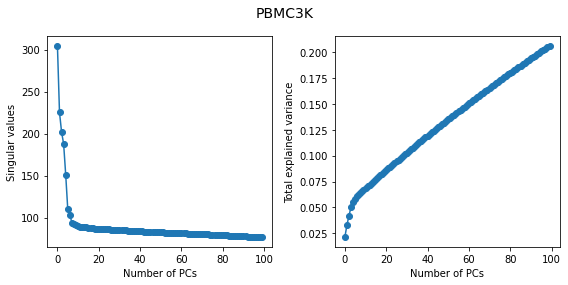

In [11]:
plot_sing_vals_exp_var(dict_print, fontsize=10)
# datset=False means that the dictionary is not a dictionary of dictionaries with multiple datasets, but
# a dictionary with results from a single dataset

In conclusion, single-cell genomics data should be _a priori_ considered as not having linearly correlated variables, unless shown otherwise. Thus, PCA is unsuited for the preprocessing of each and every single dataset, contrary to what is currently done. 